In [60]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import copy
import random
import warnings
from sklearn import linear_model
from sklearn import svm
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
warnings.filterwarnings('ignore')

random.seed(42)

In [61]:
df = pd.read_csv('./owid-covid-data.csv',index_col=0)
df.info()
filterX = ['new_cases',"weekly_new_cases_average","weekly_new_tests_average","positive_rate"]
filterY = ['new_cases']
df = df[filterX]
df1 = copy.deepcopy(df)
#df1["total_vaccinations"] = df1["total_vaccinations"].fillna(0)
#df1["people_vaccinated"] = df1["people_vaccinated"].fillna(0)
#df1["people_fully_vaccinated"] = df1["people_fully_vaccinated"].fillna(0)


<class 'pandas.core.frame.DataFrame'>
Index: 416 entries, 2020-03-01 to 2021-04-20
Data columns (total 29 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   total_cases                                           416 non-null    int64  
 1   new_cases                                             416 non-null    int64  
 2   weekly_new_cases_average                              416 non-null    int64  
 3   new_cases_yesterday                                   416 non-null    int64  
 4   new_deaths                                            416 non-null    int64  
 5   weeky_new_deaths_average                              416 non-null    int64  
 6   new_deaths_yesterday                                  416 non-null    int64  
 7   new_tests                                             416 non-null    int64  
 8   weekly_new_tests_average                         

In [62]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 416 entries, 2020-03-01 to 2021-04-20
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   new_cases                 416 non-null    int64  
 1   weekly_new_cases_average  416 non-null    int64  
 2   weekly_new_tests_average  416 non-null    int64  
 3   positive_rate             416 non-null    float64
dtypes: float64(1), int64(3)
memory usage: 16.2+ KB


In [63]:
df = df.astype(float)

In [64]:
scaler = StandardScaler()
scaler = scaler.fit(df)
df_train = scaler.transform(df)

scaler2 = StandardScaler()
scaler2 = scaler2.fit(df1)
df_train2 = scaler2.transform(df1)

In [65]:
def set_shape(fut):
    trainX = []
    trainY = []
    n_future = fut  # Number of days we want to predict into the future
    n_past = 7     # Number of past days we want to use to predict the future


    for i in range(n_past, len(df_train) - n_future +1):
        trainX.append(df_train[i - n_past:i, 0:df_train.shape[1]])
        trainY.append(df_train[i + n_future - 1:i + n_future, 0])

    trainX, trainY = np.array(trainX), np.array(trainY)

    print('trainX shape == {}.'.format(trainX.shape))
    print('trainY shape == {}.'.format(trainY.shape))
    return trainX,trainY

In [66]:
def set_shape2(fut):
    trainX = []
    trainY = []
    n_future = fut  # Number of days we want to predict into the future
    n_past = 7     # Number of past days we want to use to predict the future


    for i in range(n_past, len(df_train2) - n_future +1):
        trainX.append(df_train2[i - n_past:i, 0:df_train.shape[1]])
        trainY.append(df_train2[i + n_future - 1:i + n_future, 0])

    trainX, trainY = np.array(trainX), np.array(trainY)

    print('trainX shape == {}.'.format(trainX.shape))
    print('trainY shape == {}.'.format(trainY.shape))
    return trainX,trainY

In [67]:

def test_train_split(trainX, trainY):
    testX = trainX[-142:]
    testY = trainY[-142:]

    #testX = testX[90:105]
    #testY = testY[90:105]

    trainX = trainX[:-142]
    trainY = trainY[:-142]

    trainDates = df1.index[:-142]
    testDates = df1.index[-142:]

    #trainDates = trainDates[90:105]
    #testDates = testDates[90:105]

    print('trainX shape == {}.'.format(trainX.shape))
    print('trainY shape == {}.'.format(trainY.shape))

    print('testX shape == {}.'.format(testX.shape))
    print('testY shape == {}.'.format(testY.shape))
    return testX,testY,trainDates,testDates,trainX,trainY

In [68]:
def plot(classifiers_names, evaluation):
    fig, axs = plt.subplots(1,3, figsize=(20, 5))
    axs = axs.ravel()

    # print(classifiers_names)

    for i in range(3):
        axs[i].bar(classifiers_names,evaluation[i])
        for tick in axs[i].get_xticklabels():
            tick.set_rotation(90)
    axs[0].set_title('MSE')
    axs[1].set_title('MAE')
    axs[2].set_title('R2')
    plt.show()

In [69]:
def predict_n_days(trainX, trainY, testX, testY, testDates,n):

    classifiers = [
        svm.SVR(),
        linear_model.SGDRegressor(random_state=42),
        GradientBoostingRegressor(random_state=42),
        linear_model.ARDRegression(),
        RandomForestRegressor(random_state = 42),
        linear_model.LinearRegression()]

    nsamples, nx, ny = trainX.shape
    train_new_dataset = trainX.reshape((nsamples,nx*ny))
    nsamples, nx, ny = testX.shape
    test_new_dataset = testX.reshape((nsamples,nx*ny))


    df1['Date'] = pd.to_datetime(df1.index)

    fig, axs = plt.subplots(2,3, figsize=(30, 15))
    fig.suptitle(f'Predicting {n} day(s) ahead in the future',fontsize=30)
    classifiers_names = ['svm','SGDRegressor','GradientBoostingRegressor','ARDRegression','RandomForestRegressor','LinearRegression']

    MSE_scores = []
    MAE_scores = []
    R2_scores = []

    axs = axs.ravel()   

    i=0
    for item in classifiers:
        clf = item
        clf.fit(train_new_dataset, trainY.ravel())
        forecast = (clf.predict(test_new_dataset))
        forecast = forecast.reshape(len(forecast), 1, 1)
        forecast_copies = np.repeat(forecast, df_train.shape[1], axis=-1)
        y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]
        y_pred_future = y_pred_future[:,0]
        df_forecast = pd.DataFrame({'Date':testDates, 'Cases':y_pred_future})
        df_forecast['Date']=pd.to_datetime(df_forecast['Date'])
        axs[i].set_title(classifiers_names[i])
        axs[i].set_ylabel('Cases')
        testY_new = scaler.inverse_transform(np.repeat(testY,df_train.shape[1], axis=-1))[:,0]
        axs[i].plot(df_forecast['Date'], testY_new)
        axs[i].plot(df_forecast['Date'], df_forecast['Cases'])
        print("Mean Number of Cases: ",df_forecast['Cases'].mean())
        for tick in axs[i].get_xticklabels():
            tick.set_rotation(45)
        i+=1
        R2_scores.append(r2_score(testY,forecast.reshape(len(forecast),1)))
        MSE_scores.append(mean_squared_error(testY,forecast.reshape(len(forecast),1)))
        MAE_scores.append(mean_absolute_error(testY,forecast.reshape(len(forecast),1)))

    plt.show()
    evaluation = [MSE_scores,MAE_scores,R2_scores]
    plot(classifiers_names, evaluation)

trainX shape == (409, 7, 4).
trainY shape == (409, 1).
trainX shape == (267, 7, 4).
trainY shape == (267, 1).
testX shape == (142, 7, 4).
testY shape == (142, 1).
trainX shape == (409, 7, 4).
trainY shape == (409, 1).
trainX shape == (267, 7, 4).
trainY shape == (267, 1).
testX shape == (142, 7, 4).
testY shape == (142, 1).
Mean Number of Cases:  100268.09405024118
Mean Number of Cases:  138782.4482031023
Mean Number of Cases:  119688.07661906489
Mean Number of Cases:  123662.41472673893
Mean Number of Cases:  125930.4191737089
Mean Number of Cases:  124132.72179395152


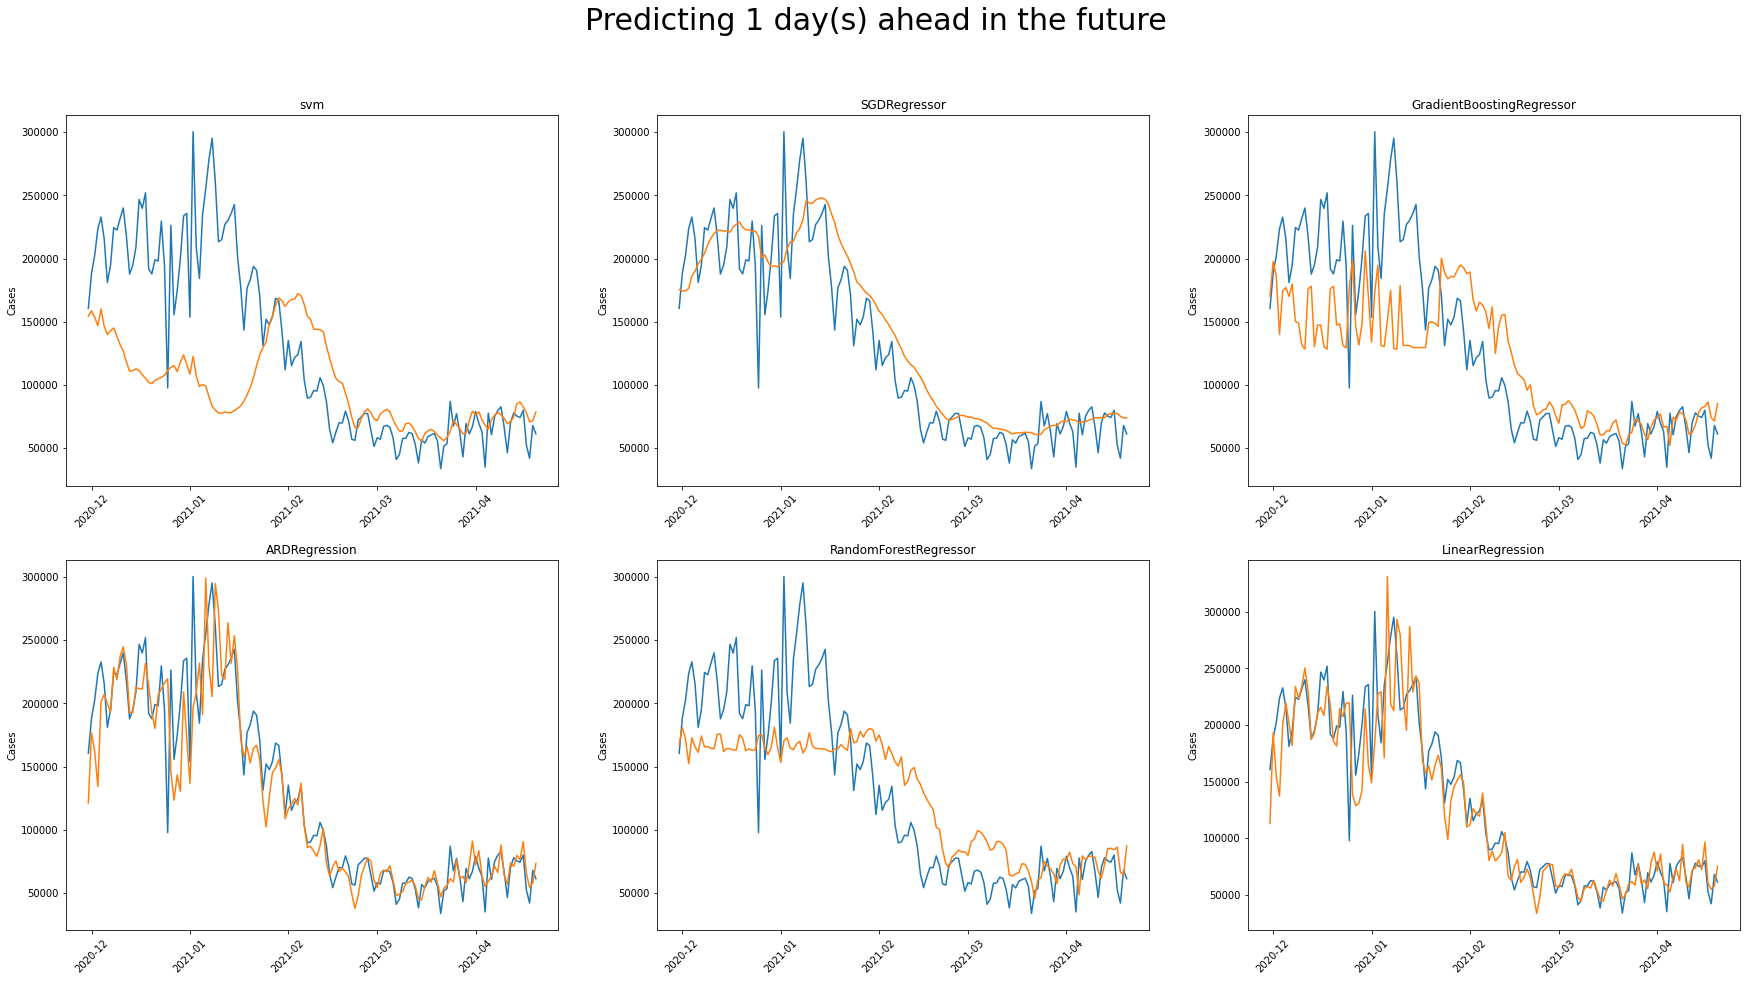

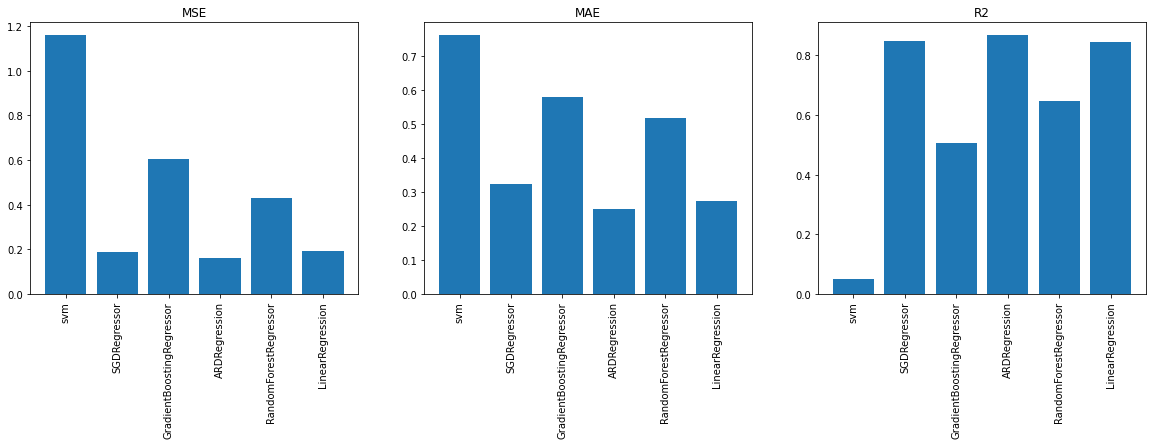

trainX shape == (408, 7, 4).
trainY shape == (408, 1).
trainX shape == (266, 7, 4).
trainY shape == (266, 1).
testX shape == (142, 7, 4).
testY shape == (142, 1).
trainX shape == (408, 7, 4).
trainY shape == (408, 1).
trainX shape == (266, 7, 4).
trainY shape == (266, 1).
testX shape == (142, 7, 4).
testY shape == (142, 1).
Mean Number of Cases:  100780.03937508327
Mean Number of Cases:  135297.60034520857
Mean Number of Cases:  123788.4527088786
Mean Number of Cases:  122389.36204149992
Mean Number of Cases:  126524.36745892021
Mean Number of Cases:  122882.36297762352


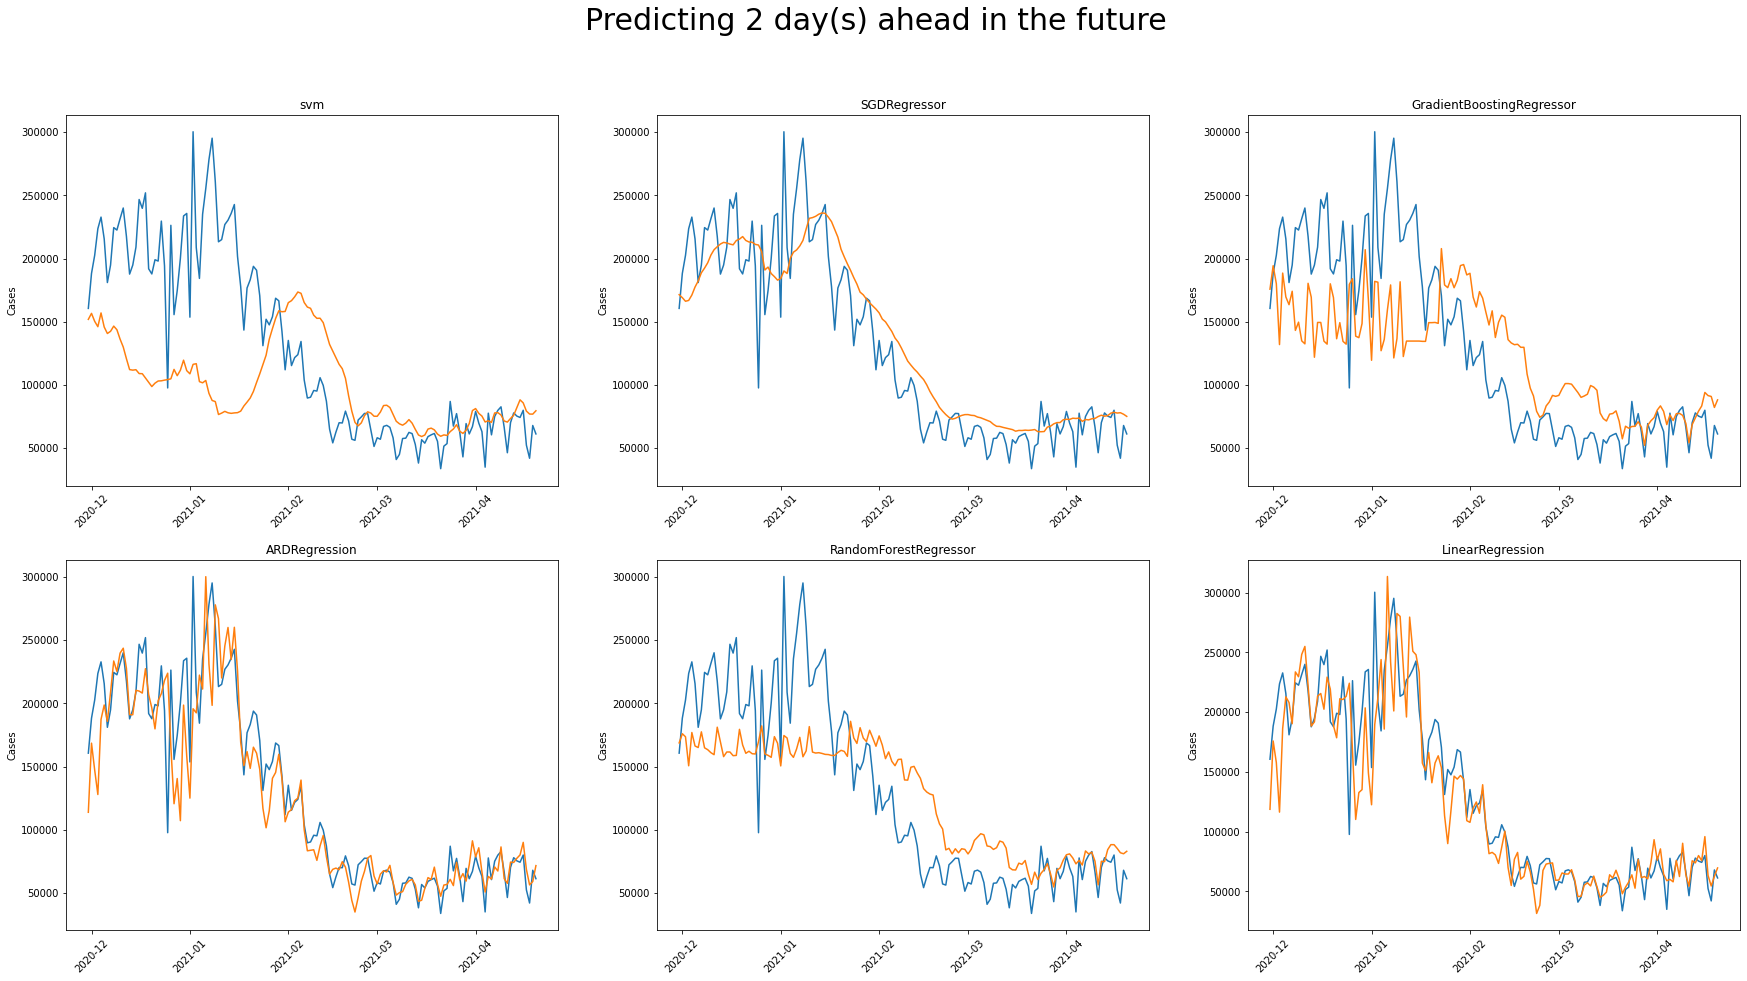

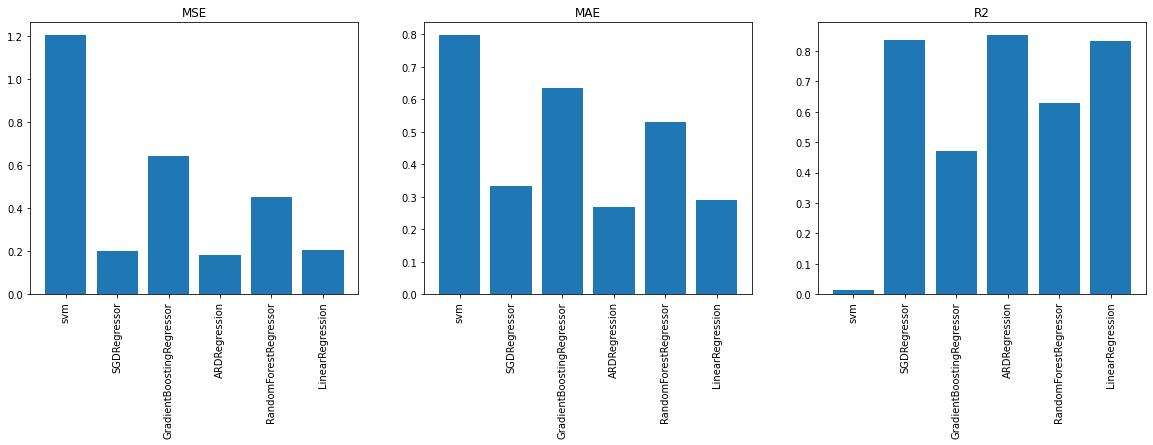

trainX shape == (407, 7, 4).
trainY shape == (407, 1).
trainX shape == (265, 7, 4).
trainY shape == (265, 1).
testX shape == (142, 7, 4).
testY shape == (142, 1).
trainX shape == (407, 7, 4).
trainY shape == (407, 1).
trainX shape == (265, 7, 4).
trainY shape == (265, 1).
testX shape == (142, 7, 4).
testY shape == (142, 1).
Mean Number of Cases:  100546.10848966952
Mean Number of Cases:  140805.36629154437
Mean Number of Cases:  123368.2039050952
Mean Number of Cases:  119978.01522973536
Mean Number of Cases:  129839.11184037555
Mean Number of Cases:  118060.19659609691


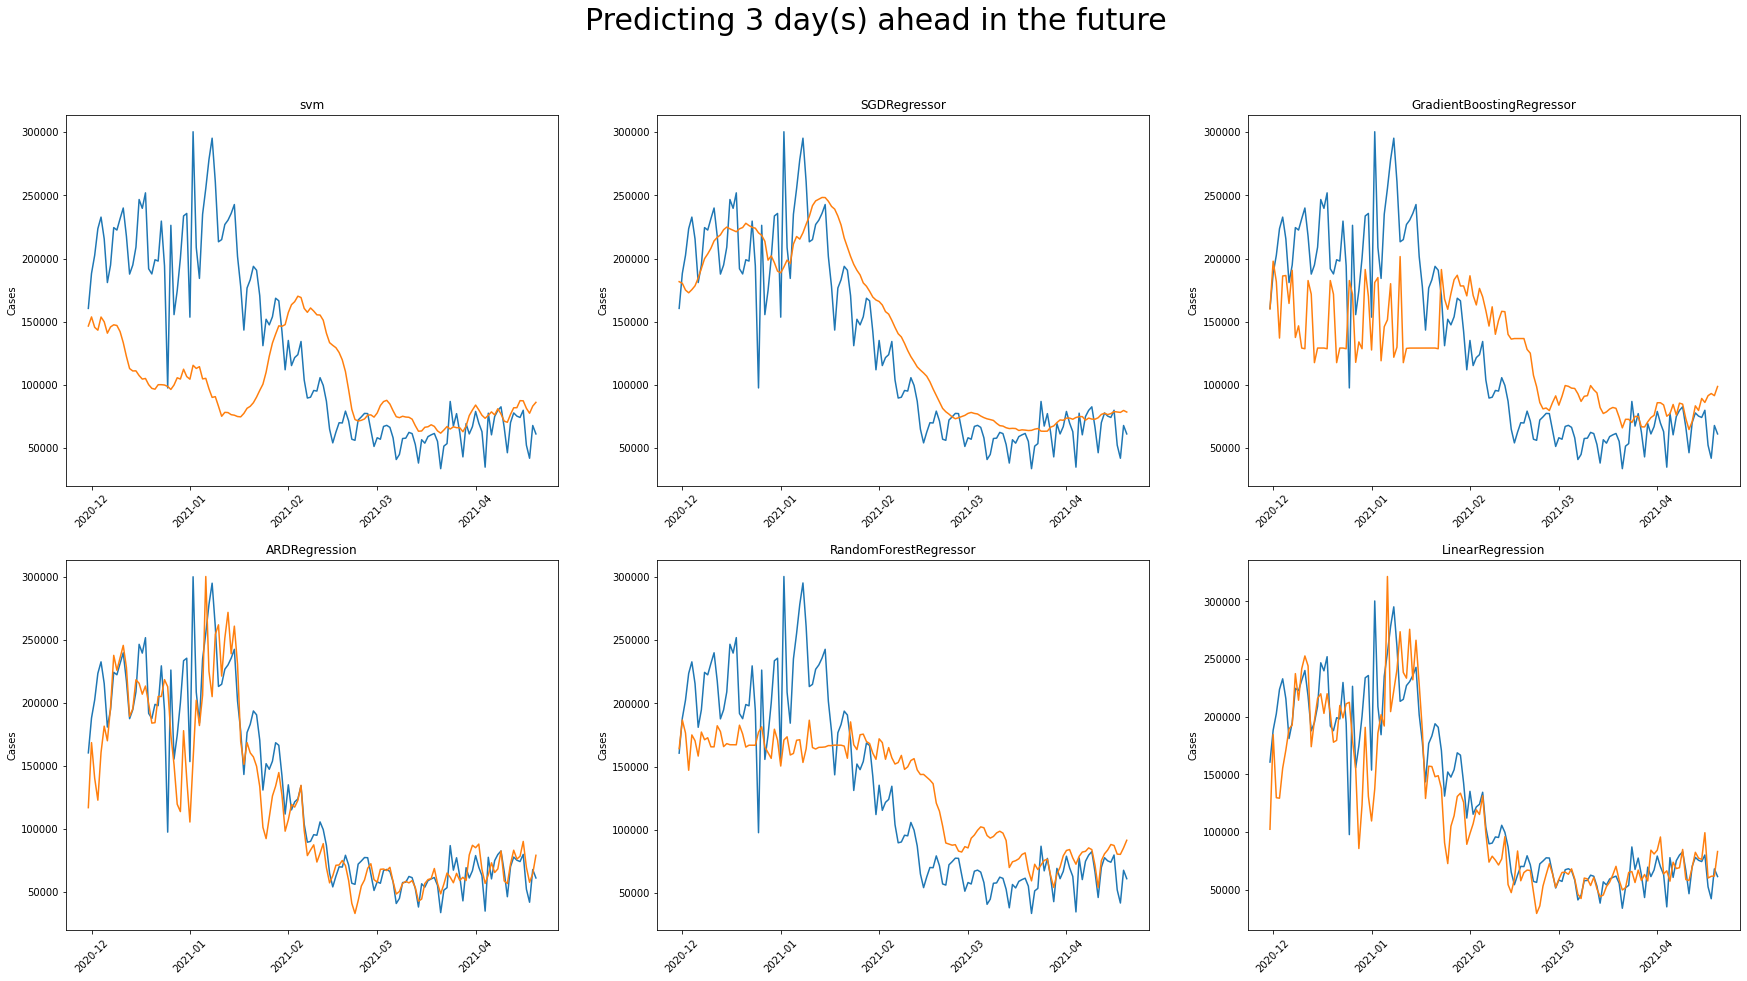

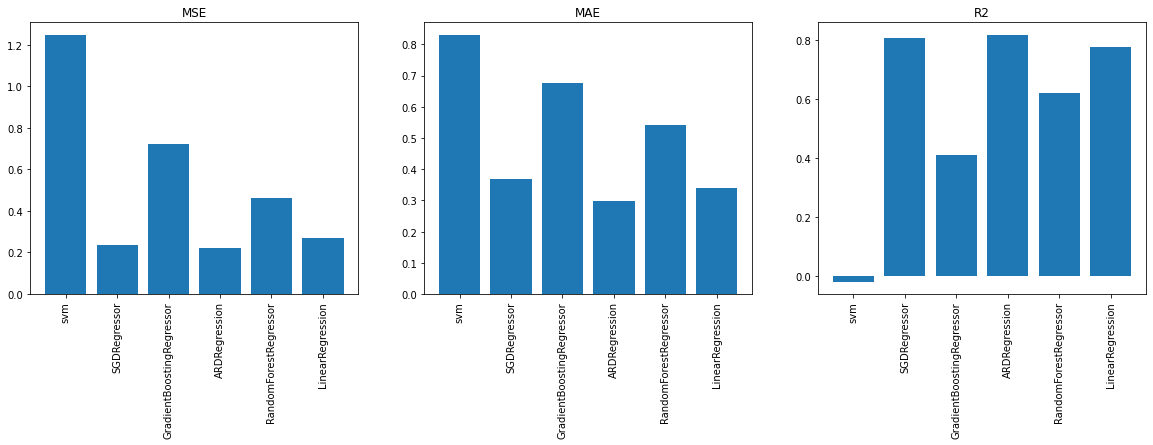

trainX shape == (406, 7, 4).
trainY shape == (406, 1).
trainX shape == (264, 7, 4).
trainY shape == (264, 1).
testX shape == (142, 7, 4).
testY shape == (142, 1).
trainX shape == (406, 7, 4).
trainY shape == (406, 1).
trainX shape == (264, 7, 4).
trainY shape == (264, 1).
testX shape == (142, 7, 4).
testY shape == (142, 1).
Mean Number of Cases:  101287.57340173026
Mean Number of Cases:  142148.19074556095
Mean Number of Cases:  123322.837955393
Mean Number of Cases:  118663.46863293367
Mean Number of Cases:  127577.83840727698
Mean Number of Cases:  114906.79209323933


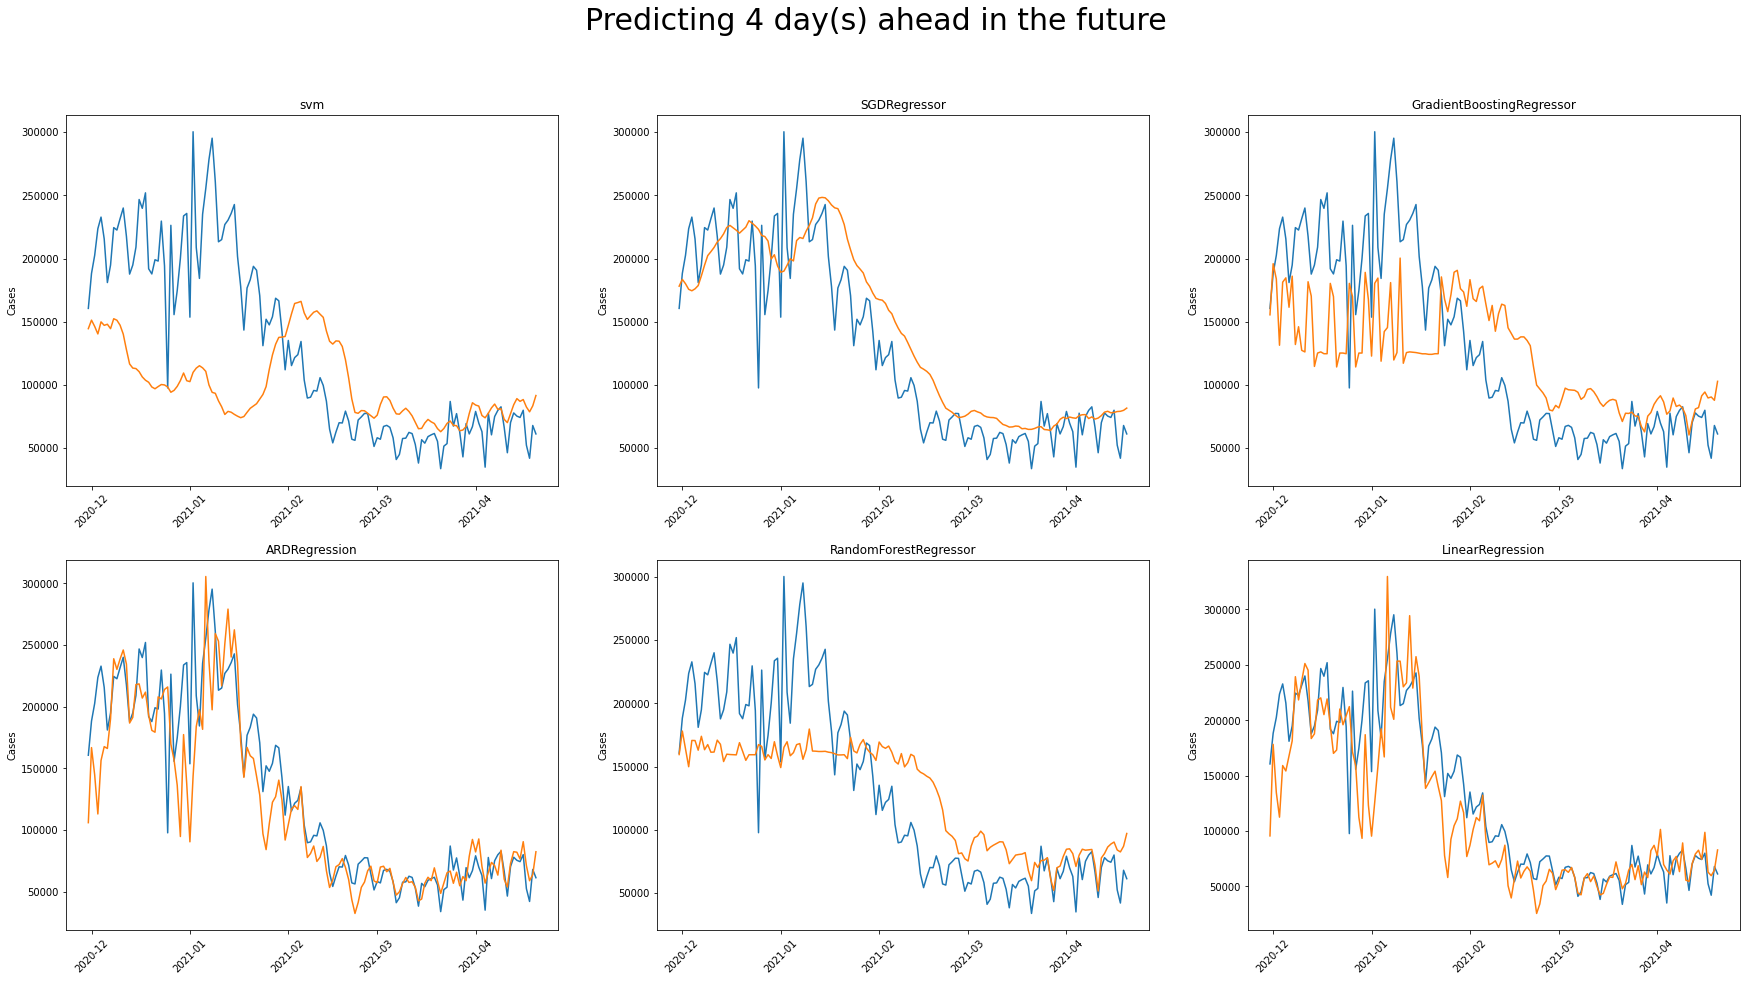

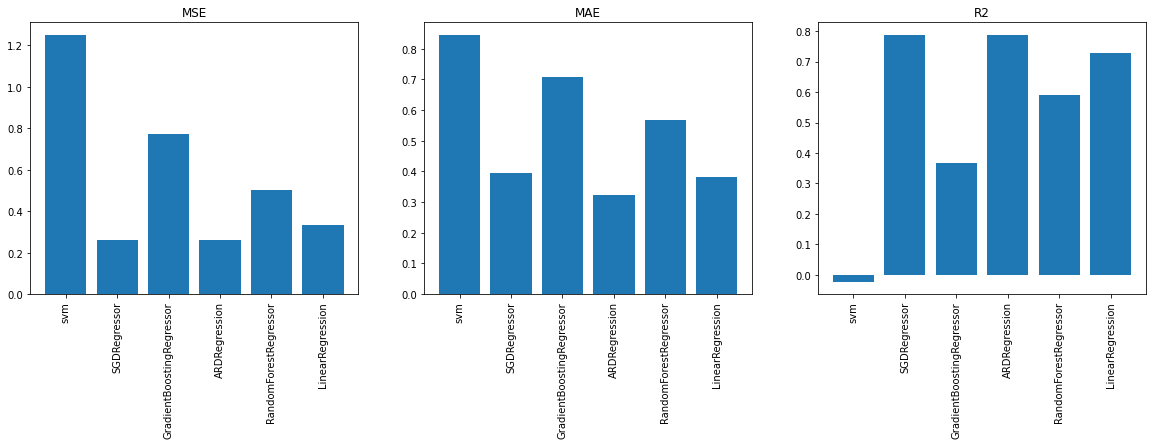

trainX shape == (405, 7, 4).
trainY shape == (405, 1).
trainX shape == (263, 7, 4).
trainY shape == (263, 1).
testX shape == (142, 7, 4).
testY shape == (142, 1).
trainX shape == (405, 7, 4).
trainY shape == (405, 1).
trainX shape == (263, 7, 4).
trainY shape == (263, 1).
testX shape == (142, 7, 4).
testY shape == (142, 1).
Mean Number of Cases:  100932.99243884435
Mean Number of Cases:  142685.8050115291
Mean Number of Cases:  121687.1876115615
Mean Number of Cases:  116097.22480007684
Mean Number of Cases:  128260.7965410798
Mean Number of Cases:  113053.37621768315


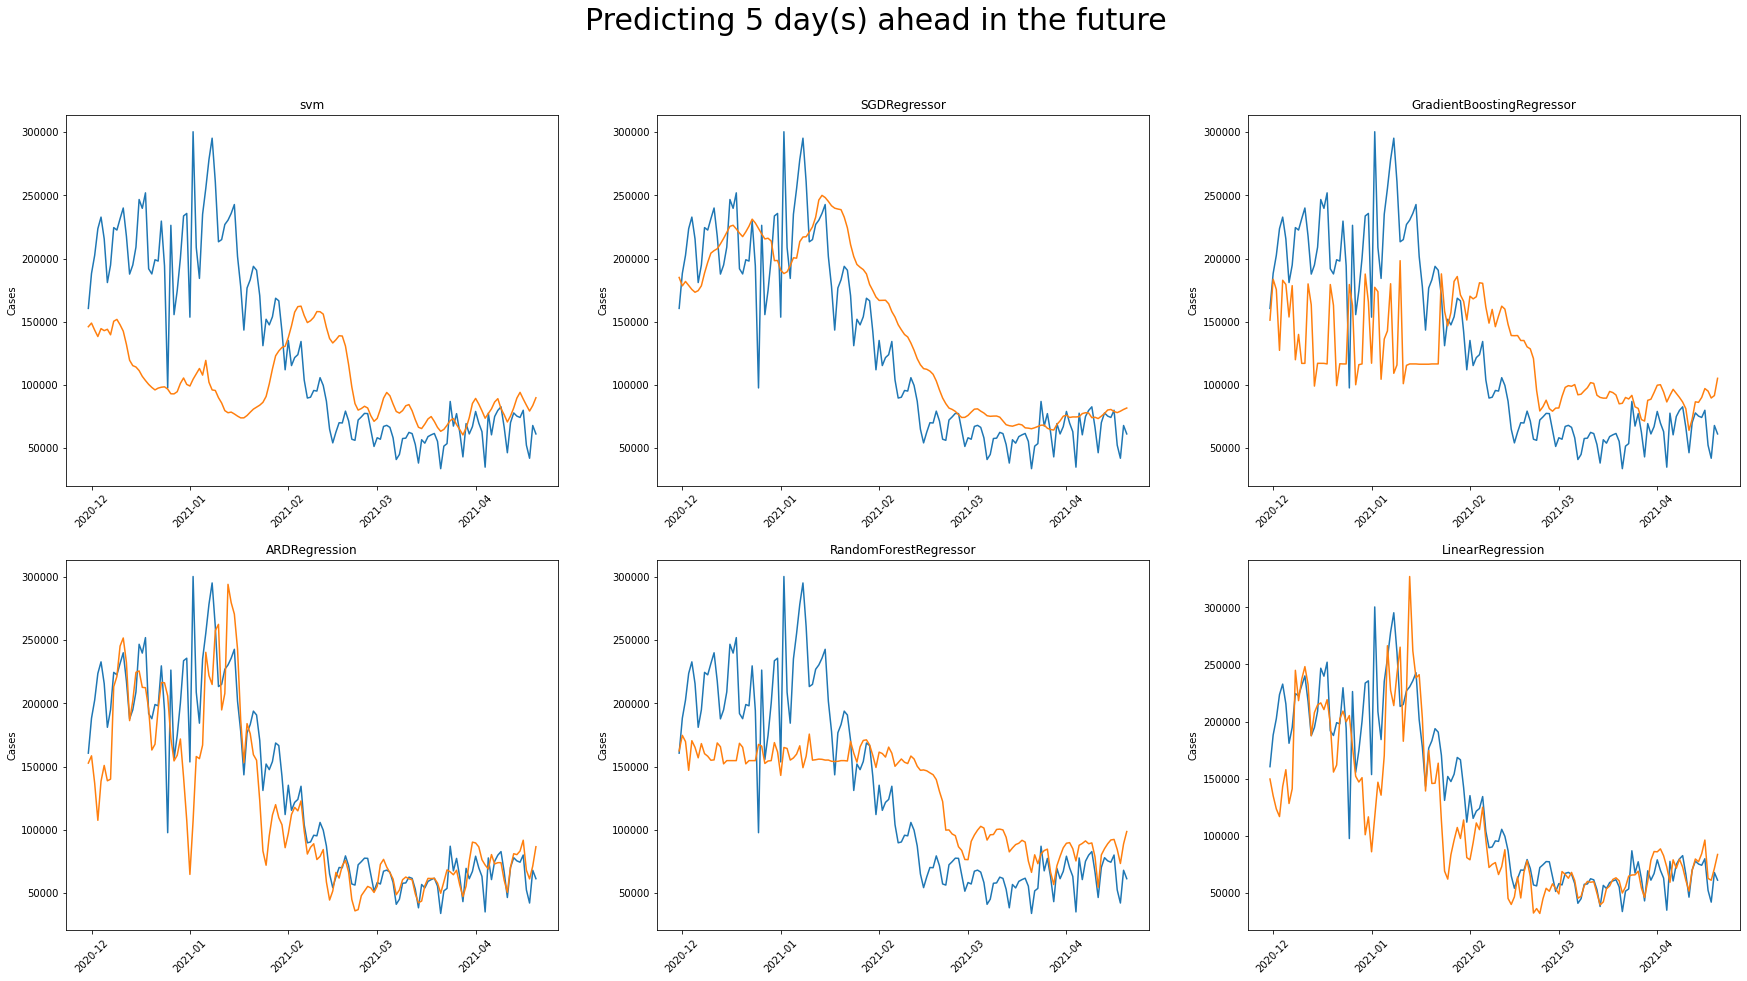

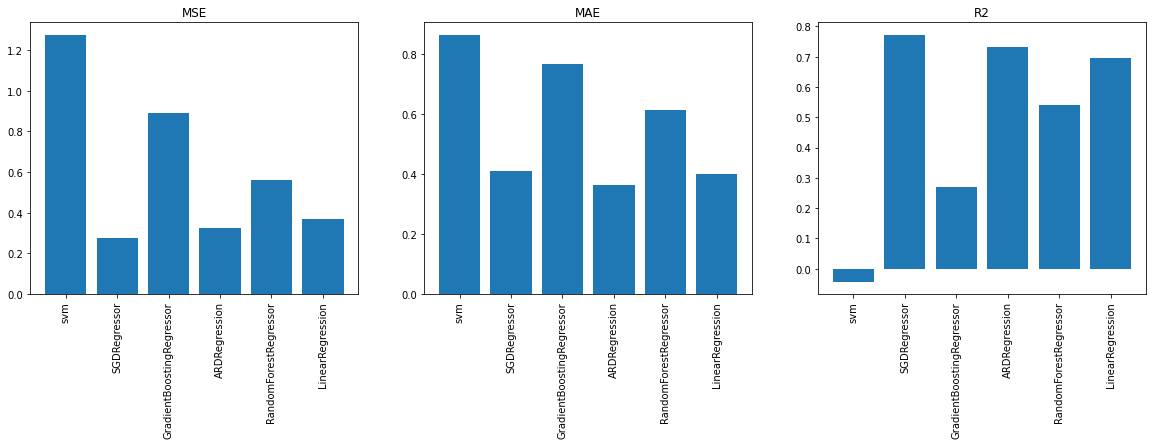

trainX shape == (404, 7, 4).
trainY shape == (404, 1).
trainX shape == (262, 7, 4).
trainY shape == (262, 1).
testX shape == (142, 7, 4).
testY shape == (142, 1).
trainX shape == (404, 7, 4).
trainY shape == (404, 1).
trainX shape == (262, 7, 4).
trainY shape == (262, 1).
testX shape == (142, 7, 4).
testY shape == (142, 1).
Mean Number of Cases:  99761.39647913596
Mean Number of Cases:  143053.79041898513
Mean Number of Cases:  123679.72774492548
Mean Number of Cases:  110353.10434266385
Mean Number of Cases:  125025.6934154929
Mean Number of Cases:  109078.43997039412


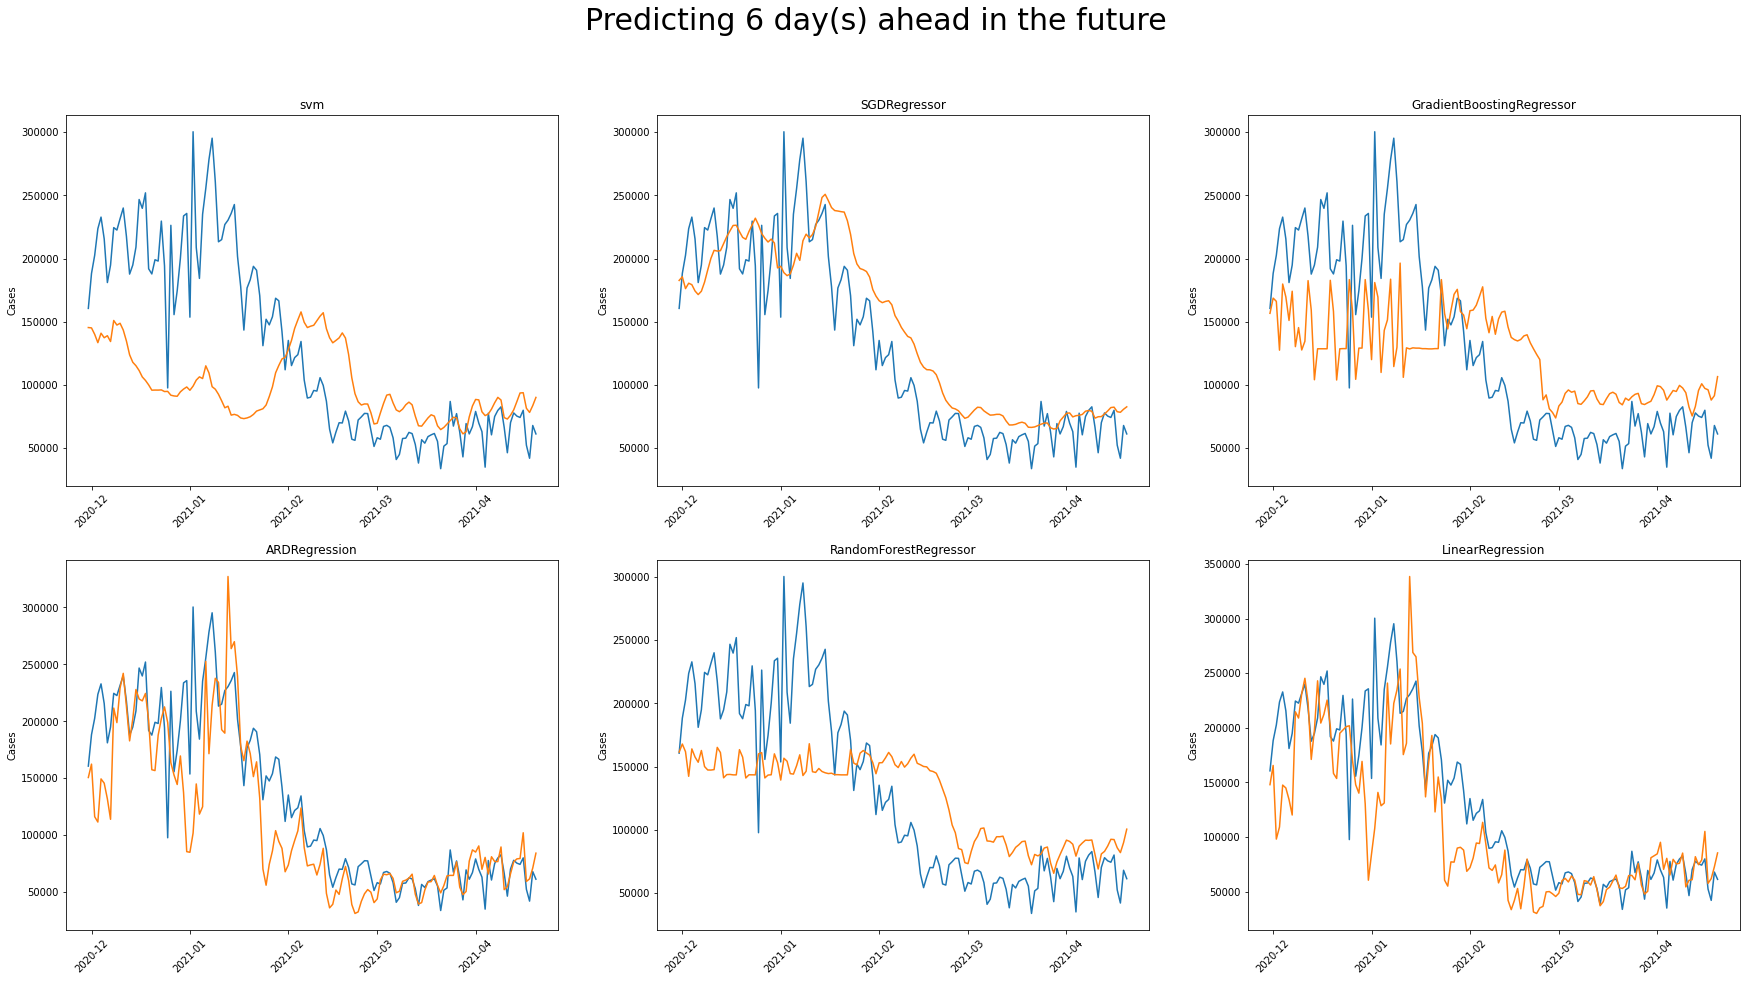

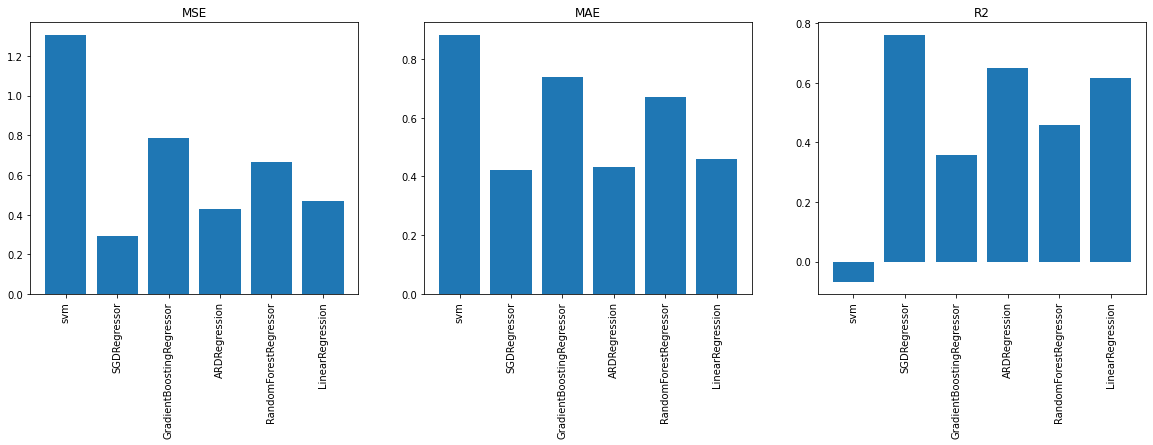

trainX shape == (403, 7, 4).
trainY shape == (403, 1).
trainX shape == (261, 7, 4).
trainY shape == (261, 1).
testX shape == (142, 7, 4).
testY shape == (142, 1).
trainX shape == (403, 7, 4).
trainY shape == (403, 1).
trainX shape == (261, 7, 4).
trainY shape == (261, 1).
testX shape == (142, 7, 4).
testY shape == (142, 1).
Mean Number of Cases:  100830.78732203829
Mean Number of Cases:  145772.59786074221
Mean Number of Cases:  117859.26478717485
Mean Number of Cases:  109638.1345939524
Mean Number of Cases:  130472.57969483567
Mean Number of Cases:  108919.31042147223


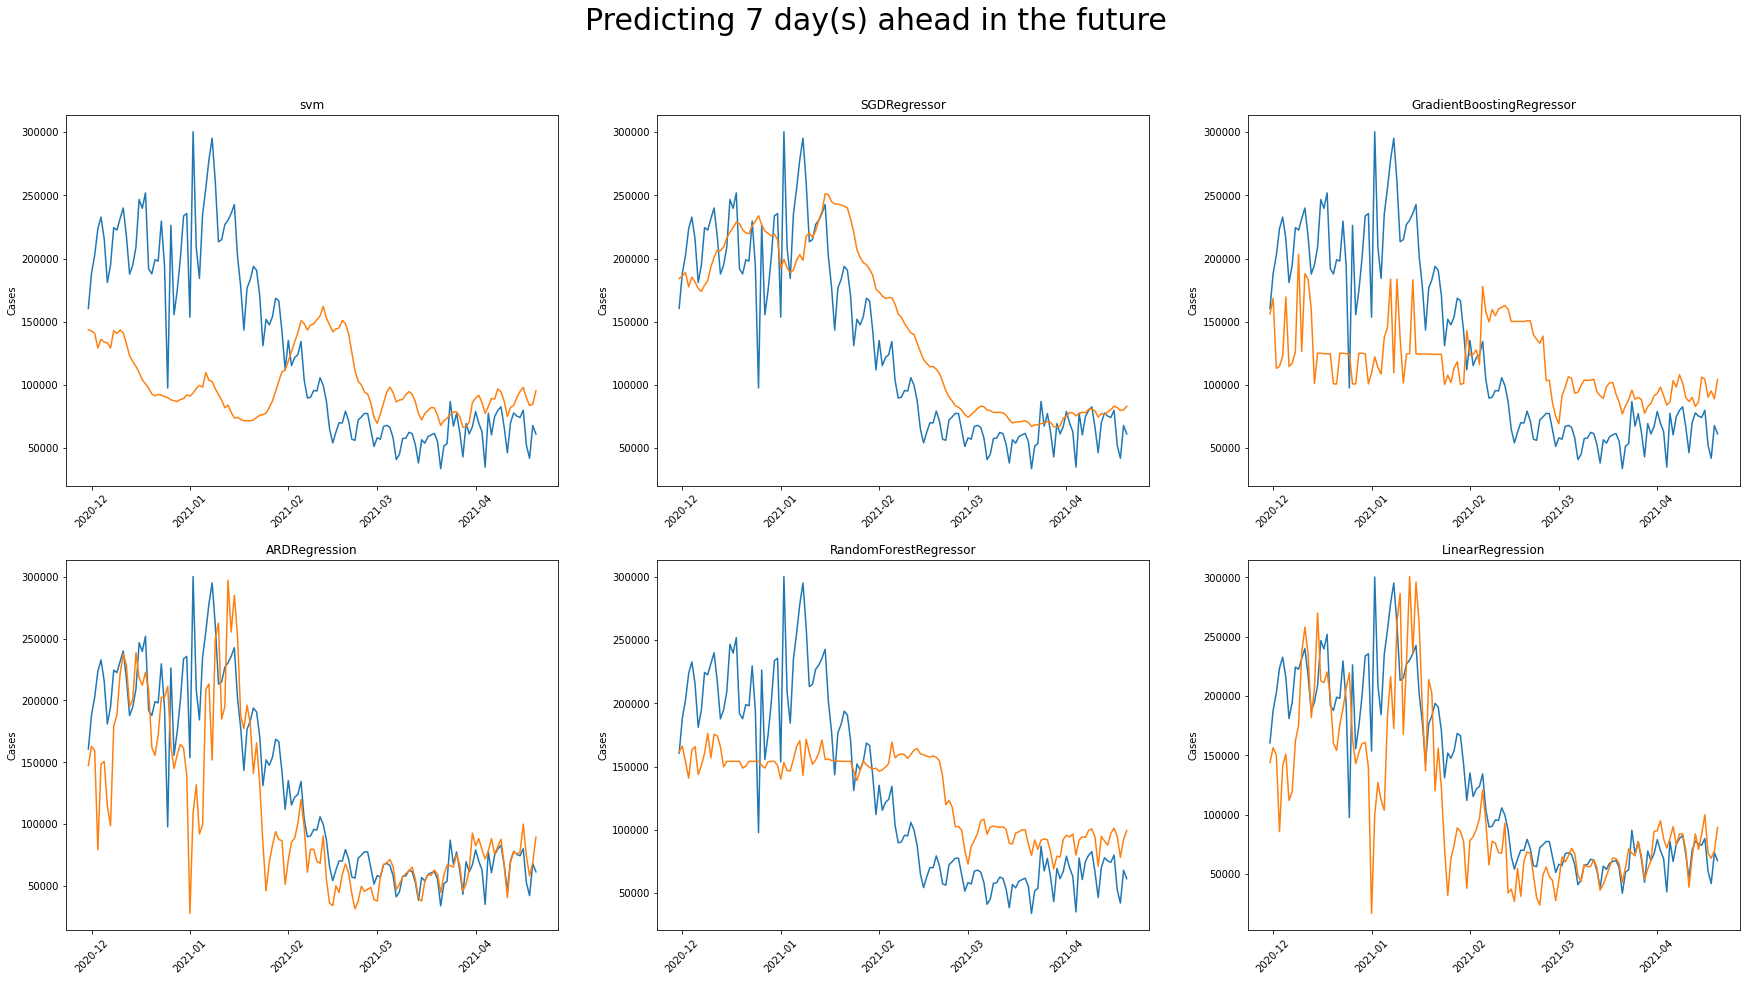

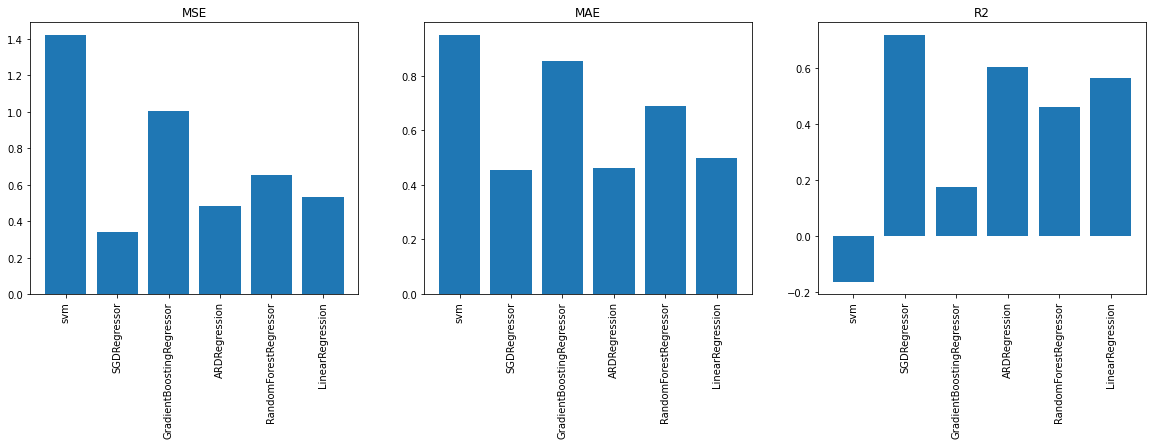

In [70]:
for i in range(1,8):
    trainX_new, trainY_new = set_shape(i)
    testX_new, testY_new,trainDates, testDates, trainX_new,trainY_new = test_train_split(trainX_new, trainY_new)
    a,b = set_shape2(i)
    testX_new, testY_new,trainDates, testDates, trainX_new2,trainY_new2 = test_train_split(a, b)
    predict_n_days(trainX_new, trainY_new, testX_new, testY_new, testDates,i)